In [2]:
%load_ext autoreload

import os, sys
sys.path.insert(0, "../")
sys.path.insert(1, '/home/j/joppich/.local/lib/python3.11/site-packages')
print(sys.path)

%autoreload 2
from flowset import *

os.environ["POLARS_MAX_THREADS"] = "8"
import polars as pl

# for downloading pathways
import urllib, zipfile

# plotting
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


['../', '/home/j/joppich/.local/lib/python3.11/site-packages', '/mnt/raidbio/extproj/projekte/FlowSets/examples', '', '/mnt/biosoft/software/python/3.11/lib/python3.11/site-packages', '/mnt/biosoft/software/python/3.11/lib64/python3.11/site-packages', '/usr/lib64/python311.zip', '/usr/lib64/python3.11', '/usr/lib64/python3.11/lib-dynload', '/home/j/joppich/.local/lib/python3.11/site-packages', '/usr/lib64/python3.11/site-packages', '/usr/lib64/python3.11/_import_failed', '/usr/lib/python3.11/site-packages']


Text(0, 0.5, 'Density of Probability')

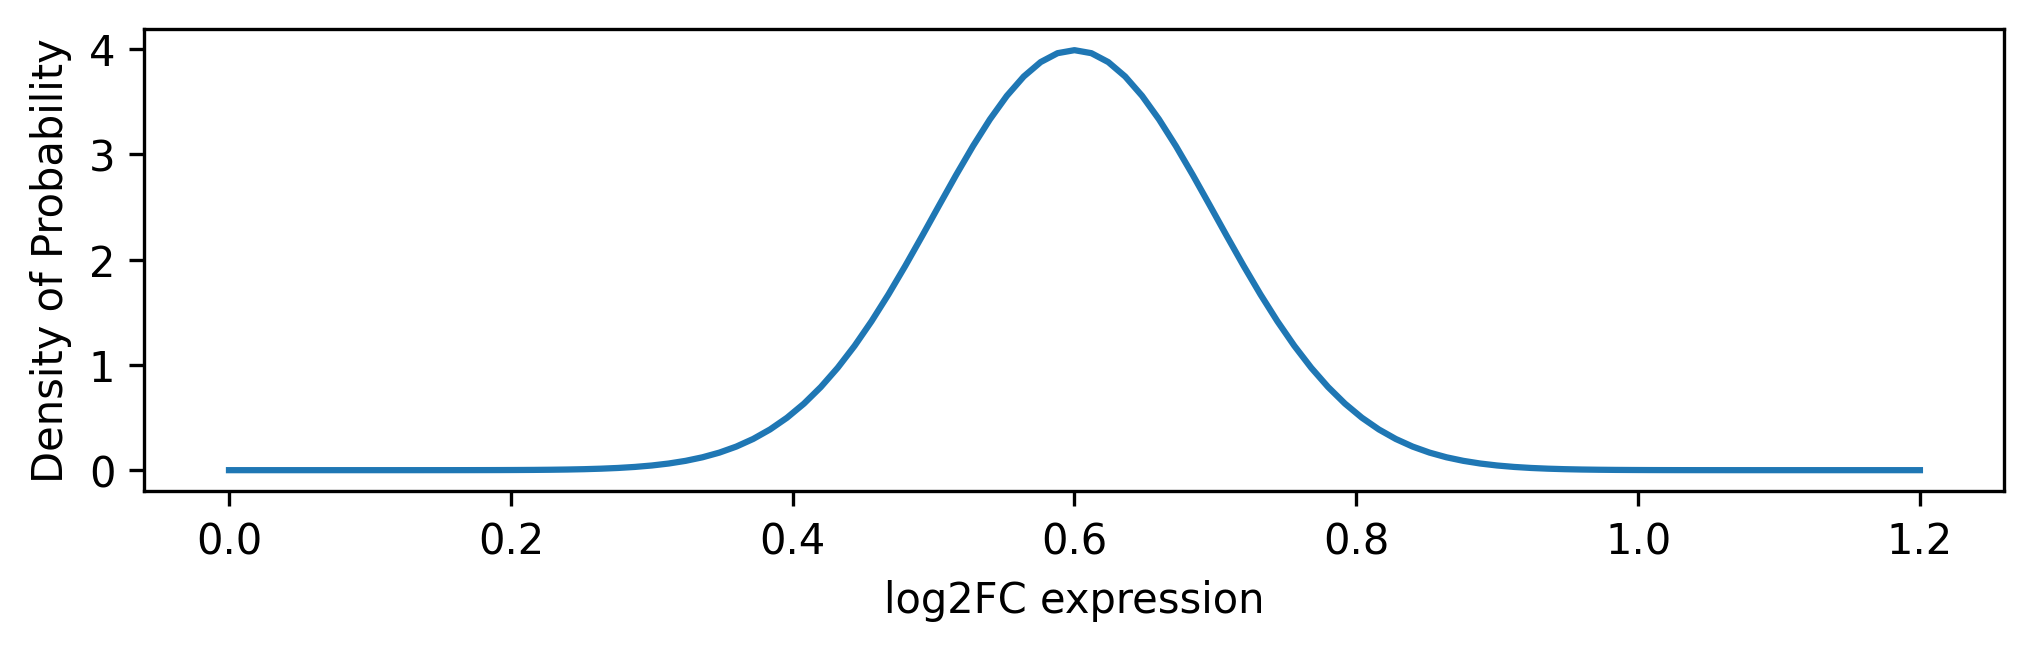

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

h = np.linspace(0, 1.2, 101)
h.sort()
hmean = 0.6
hstd = 0.1
pdf = stats.norm.pdf(h, hmean, hstd)

#with plt.xkcd():

fig = plt.figure(figsize=(8,2))
plt.plot(h, pdf) # including h here is crucial
plt.xlabel("log2FC expression")
plt.ylabel("Density of Probability")


In [4]:
exprMF = CustomFuzzyVar(np.arange(-1.5, 1.5, 0.05), 'exprMFs')
exprMF.automf(3, names=["DOWN", "NEUTRAL", "UP"], centers=[-1, 0, 1], shape="tri") 

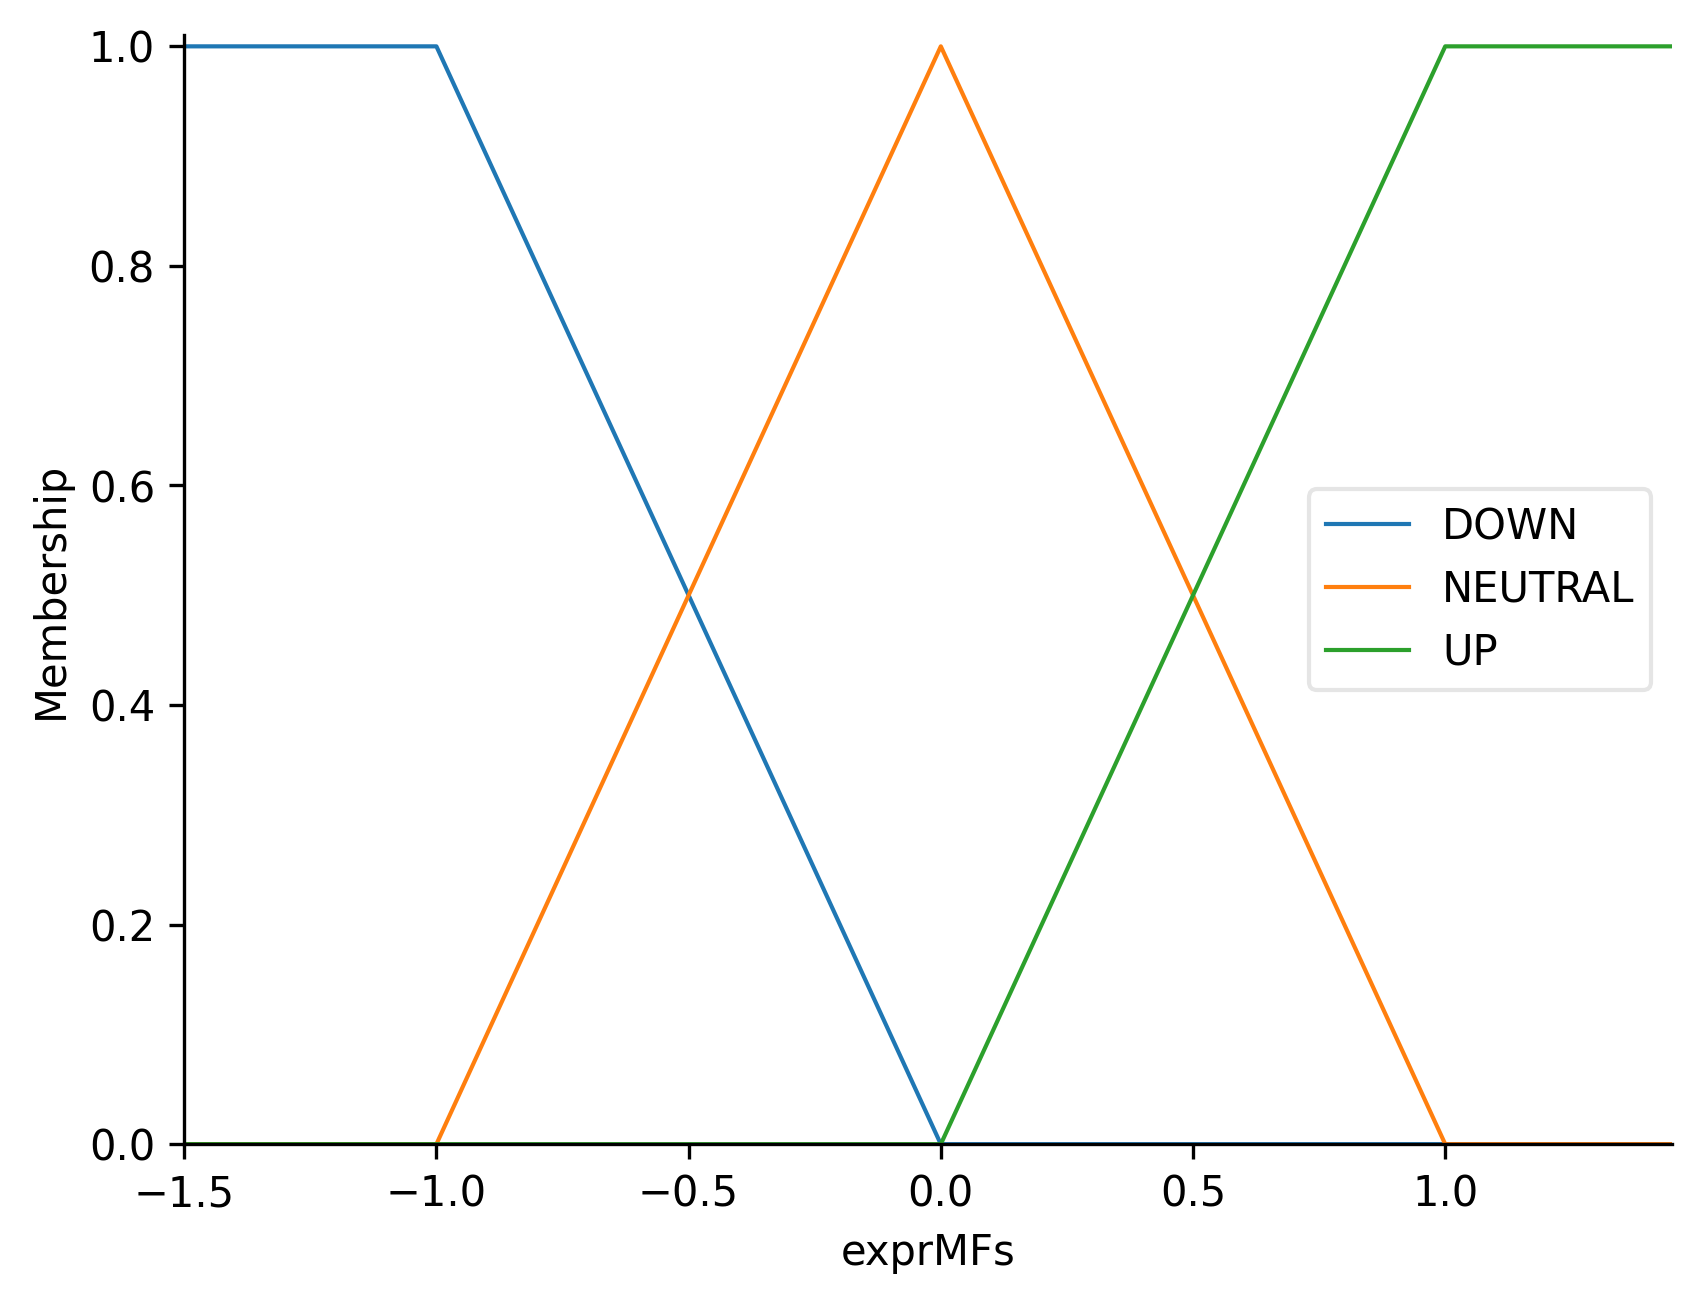

In [5]:
exprMF.view()

In [6]:

def distribution_to_fuzzy2(meanValue, sdValue, exprCells, fzMFs, threshold=0.0):

    #fuzzySetNoExpr = [0.0] * len(fzMFs.terms)
    #fuzzySetNoExpr[0] = 1.0
    fuzzySetNoExpr = to_fuzzy(0, fzMFs)
    fuzzySet = [0.0] * len(fzMFs.terms)

    if sdValue is None:
        fuzzySet =  to_fuzzy(meanValue, fzMFs)
        #fuzzySet = (1-exprCells) * np.array(fuzzySetNoExpr) + exprCells * fuzzySet
        #fuzzySet[fuzzySet < threshold] = 0
        #return [list(x) for x in zip(fzMFs.terms, to_fuzzy(meanValue, fzMFs))]


    if np.isnan(meanValue) or ((not sdValue is None) and np.isnan(sdValue)):
        fuzzySet = fuzzySetNoExpr
        #return [list(x) for x in zip(fzMFs.terms, fuzzySet)]
        return [x for x in fuzzySet]

    fzs = []
    
    if not sdValue is None:
        normValues = np.random.normal(meanValue, sdValue, 100)
        for v in normValues:
            fval = to_fuzzy(v, fzMFs)
            fzs.append(fval)
            fuzzySet += fval

        fuzzySet = fuzzySet / len(normValues)   

    fuzzySet = (1-exprCells) * np.array(fuzzySetNoExpr) + exprCells * fuzzySet
    fuzzySet[fuzzySet < threshold] = 0
    
    fuzzySet = np.array(fuzzySet, dtype=np.float32) # this should always match identify_threshold_level 
    fuzzySet = fuzzySet / np.sum(fuzzySet)
    
    outset = [x for x in fuzzySet]
    #return [list(x) for x in zip(fzMFs.terms, fuzzySet)]
    print(outset)
    return fzs

In [7]:
_ = distribution_to_fuzzy2(0.6, None, 1.0, exprMF)

[0.0, 0.4, 0.6]


In [8]:
fvals = distribution_to_fuzzy2(0.6, 0.1, 1.0, exprMF)

[0.0, 0.39794368, 0.6020563]


In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame.from_records(fvals)
df.columns = ["DOWN", "NEUTRAL", "UP"]
df

,DOWN,NEUTRAL,UP
0,0.0,0.359366,0.640634
1,0.0,0.323102,0.676898
2,0.0,0.439093,0.560907
3,0.0,0.365989,0.634011
4,0.0,0.418531,0.581469
...,...,...,...
95,0.0,0.282033,0.717967
96,0.0,0.392991,0.607009
97,0.0,0.508046,0.491954
98,0.0,0.411663,0.588337


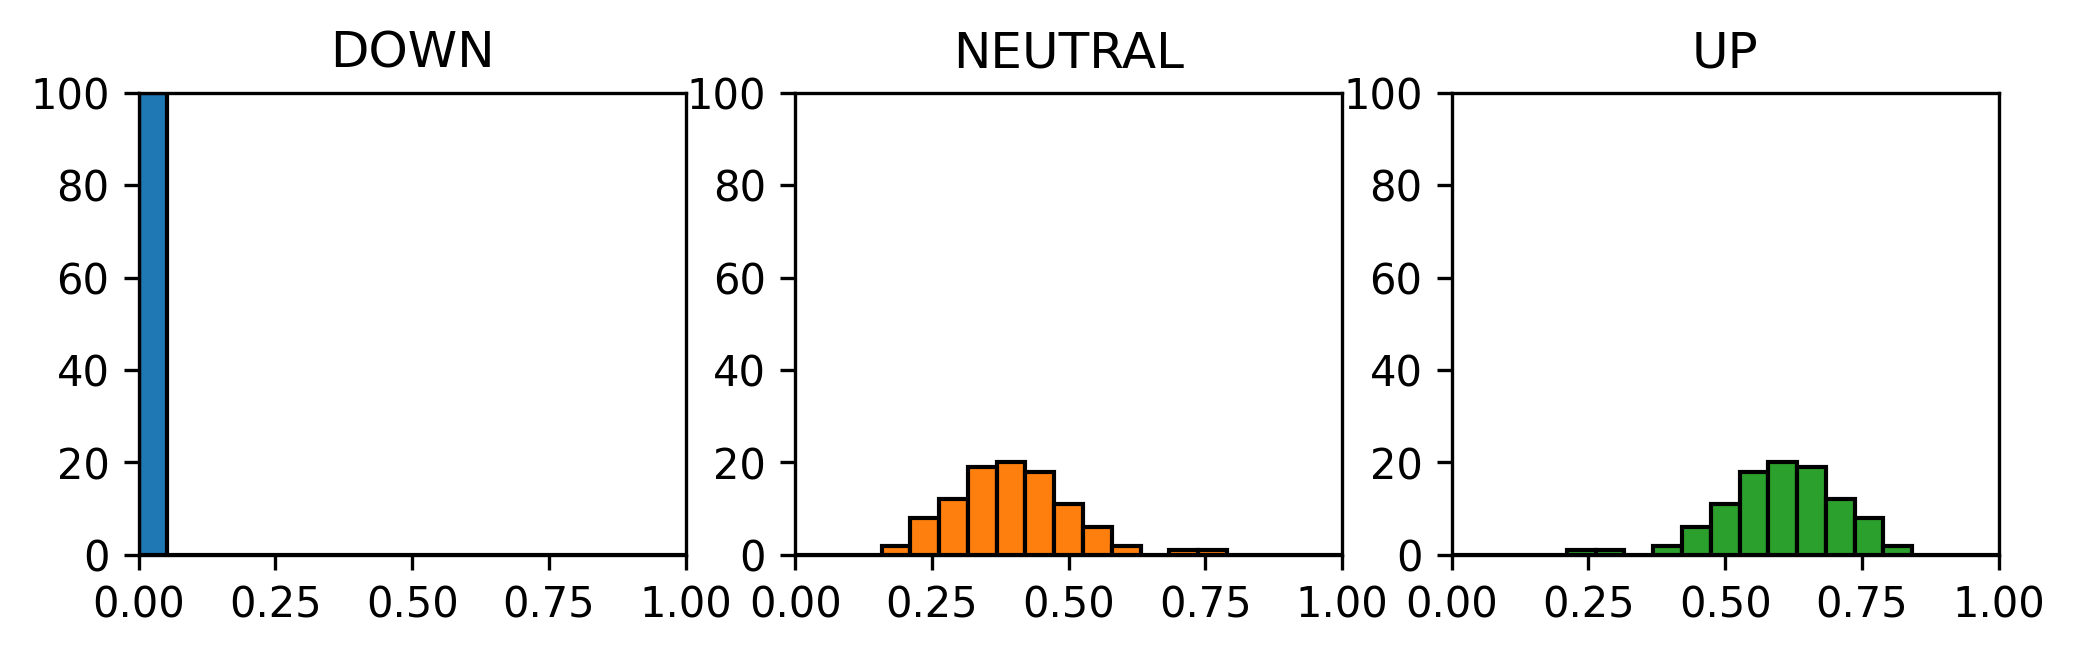

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import zip_longest

# Dictionary of color for each species
color_d = dict(zip_longest(df.columns, 
                           plt.rcParams['axes.prop_cycle'].by_key()['color']))

color_d = {'DOWN': '#1f77b4', 'NEUTRAL': '#ff7f0e', 'UP': '#2ca02c', None: '#17becf'}

bins = np.linspace(0, 1, 20)

# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(ncols=len(df.columns), figsize=(8, 2))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(df.columns):
    ax[i].hist(df[col], ec='k', bins=bins, color=color_d[col])
    ax[i].set_title(col)

    # same xlim for each so we can see differences
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 100)
    
plt.savefig("distribution_example.pdf")
plt.savefig("distribution_example.png")